# Step 1. EDA

In [1]:
#Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

c:\Users\kurom\anaconda3\envs\dl-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
financial_news = pd.read_csv('all-data.csv', encoding='latin', header=None) #read csv set header to none because columns have no title
financial_news.rename(columns={0: 'label', 1:'news'}, inplace=True) #rename columns

In [3]:
#Check DF head and Tail
financial_news.head()
financial_news.tail()

,label,news
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
4845,negative,Sales in Finland decreased by 10.5 % in Januar...


In [4]:
#Check shape of train df
financial_news.shape

(4846, 2)

In [5]:
#Check information of df
#we can see there is no missing values 
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   news    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


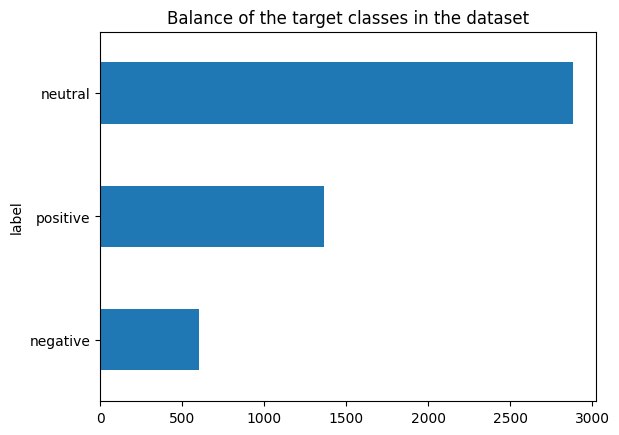

label
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [6]:
#Check balance of the data set
financial_news['label'].value_counts(ascending=True).plot.barh()
plt.title("Balance of the target classes in the dataset")
plt.show()

#We can notice that the data set is imbalanced
print(financial_news['label'].value_counts())

In [8]:
#Check the maximum lenght of the documents
financial_news['len'] = financial_news['news'].apply(lambda text: len(text.split()))
financial_news['len'].max()

81

In [9]:
financial_news.drop(columns={'len'}, inplace=True)
financial_news.head(3)

,label,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...


# Step 2. Pre-processing

In [10]:
#First let's map the labels to integers

lable_map = {'negative': -1, 'neutral': 0, 'positive': 1}
financial_news['label'] = financial_news['label'].map(lable_map)
financial_news.head()

,label,news
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,-1,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...


### Approach 1. Downsampling

In [23]:
# Let's downsample positive and neutral labels to create a balanced data set
financial_news_ds = financial_news.copy() # Copy DF

#Now let's separate our 3 classes to perform downsample
financial_news_n = financial_news_ds.loc[financial_news_ds.label == -1] #Negative label
financial_news_0 = financial_news_ds.loc[financial_news_ds.label ==  0] #Neutral label
financial_news_1 = financial_news_ds.loc[financial_news_ds.label ==  1] #Positive label 

In [24]:
#Check separated labels
financial_news_n['label'].unique()
financial_news_0['label'].unique()
financial_news_1['label'].unique()

array([1], dtype=int64)

In [25]:
#Downsample positive and neutral labels to be same length as negative label
financial_news_0 = financial_news_0.iloc[0:604, :]
financial_news_1 = financial_news_1.iloc[0:604, :]

In [27]:
#Check shapes
financial_news_0['label'].shape
financial_news_1['label'].shape

(604,)

In [ ]:
#put everything together again 